In [2]:
%pip install scipy numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 31.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 32.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 31.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


a =0.005138404146200014 ± 0.011741534007004714
b =0.20485337676602858 ± 0.009130730933177166


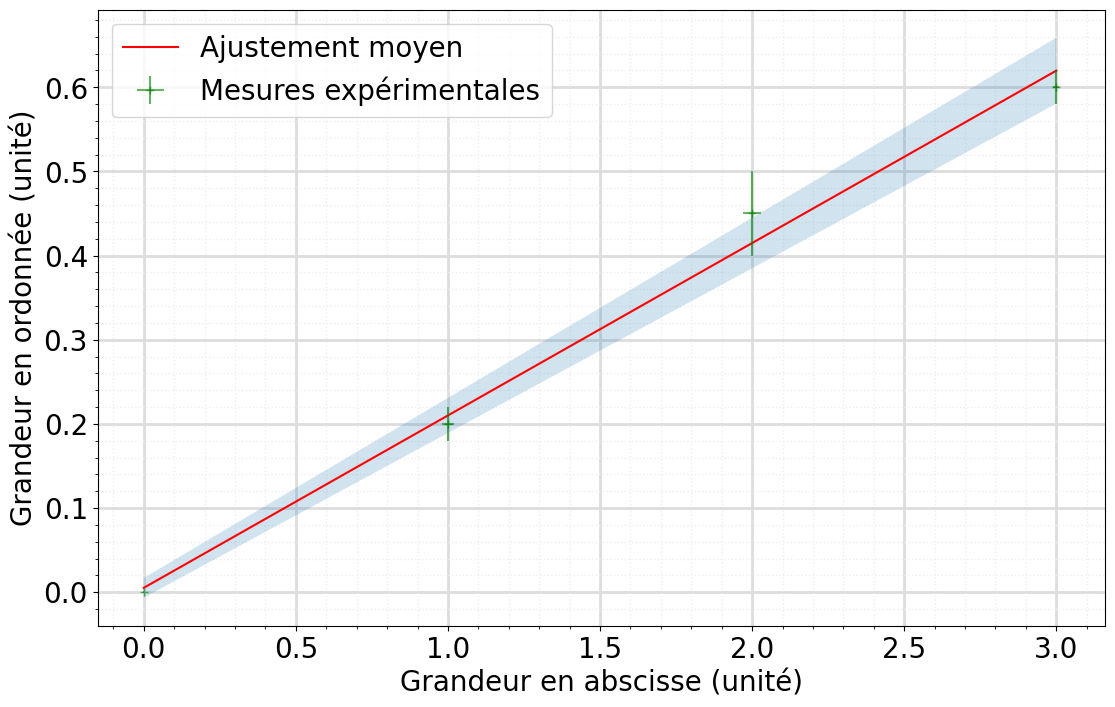

<Figure size 640x480 with 0 Axes>

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  9 17:20:09 2024

@author: brian
objectifs du TP : 
    - caractériser le bruit du générateur basse fréquence intégré à l'oscilloscope
    - Comprendre et prendre en main un algorithme de monte-carlo
    - mettre en évidence le phénomène de résonance stochastique
"""

# en cas d'erreur mentionnant scipy lors de la première installation, installer scipy en copiant la commande suivante dans la console : pip install scipy

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit


def modele_affine(x, a, b):
    """ Modèle d'ajustement affine
    ATTENTION : il prend en entrée "x" un array numpy et ressort en sortie un array numpy
    Si vous lui donnez pour x une liste b*x la concaténera, pour peu que b soit un entier 
    a est l'odronnée à l'origine et b le coefficient directeur
    """
    return (a+b*x)

def modele_res_stochastique(x, N,C):
    """ Modèle d'ajustement de la résonance stochastique
    ATTENTION : il prend en entrée "x" un array numpy et ressort en sortie un array numpy
    Si vous lui donnez pour x une liste il plantera.
    N est le nombre de tirages aléatoires
    C est la valeur-seuil à dépasser (normalisée // x) pour déclencher la bascule du comparateur 
    """
    return 1-(0.5-0.5*special.erf(-C/(np.sqrt(2)*x)))**N

plt.close('all') #On ferme tout graphique précédemment ouvert



fig,ax = plt.subplots(figsize=(13, 8))

verbose = False #permet d'afficher tous les tirages aléatoires sur le graphique, comme sur la première figure de la page 5 du polycopié



x=[0,1,2,3]
deltax=[0.001,0.02,0.03,0.01]# Delta x donnant l'intervalle de confiance à 95% pour 

y=[0.0003,0.2,0.45,0.6]
deltay = [0.0004, 0.02,0.05,0.02]


modele = modele_affine #Pour changer le modèle d'ajustement, remplacer modele_affine par le nom de la fonction d'ajustement que vous souhaitez utiliser



# On ajuste la fonction en utilisant curve_fit (minimisation de chi²)


N = int(1e3) #on réalise N tirages aléatoires successifs, avec les N ajustements par minimisation de chi²

parama=[] #liste servant au stockage de a, premier paramètre d'ajustement
paramb=[] #liste servant au stockage de b, deuxième paramètre d'ajustement

for i in range(N):
    xtemp = [x[k]+ np.random.uniform(-deltax[k],deltax[k])for k in range(len(x))]#tirage d'une liste temporaire de valeurs d'abscisse, parmi l'intervalle uniforme donné
    ytemp = [y[k]+ np.random.uniform(-deltay[k],deltay[k])for k in range(len(y))]# idem pour les ordonnées
    
    tempparam, tempcov = curve_fit(modele, xtemp, ytemp) #les paramètres optimaux obtenus par l'algorithme sont stockés dans tempparam.
    #pour changer de modèle d'ajustement, remplacer modele_affine par la fonction que vous souhaitez utiliser pour l'ajustement.
    
    #initial_guess = [1e5, 3e2] 
    #tempparam, tempcov = curve_fit(modele, xtemp, ytemp, p0=initial_guess) #Si l'algorithme d'ajustement a du mal à converger, vous pouvez le lancer en lui proposant des conditions initiales
    #manuellement, par essai-erreur en traçant vous-même la courbe que donne la condition initiale, vous pouvez vous approcher de la courbe physique pour
    #faciliter le travail de l'algorithme. Pour utiliser votre condition initiale, décommenter la ligne "initial_guess" et la ligne suivante, et commenter votre ligne réalisant actuellement le curve_fit
    
    parama.append(tempparam[0])#stockage de la valeur 1er paramètre d'ajustement
    paramb.append(tempparam[1])
    
    if verbose : #permet d'afficher tous les tirages aléatoires sur le graphique, comme sur la première figure de la page 5 de l'énoncé
        x_fit = np.linspace(min(x), max(x), 100) #On place 100 points sur l'intervalle sur lequel varie x pour tracer joliement notre ajustement
        y_fit = modele(x_fit, tempparam[0], tempparam[1]) 
        ax.plot(x_fit, y_fit, color="red",alpha=(1/N)*(1+i),)
        ax.scatter(xtemp,ytemp,marker='o', color = 'black', linestyle= '',alpha=1/N*(1+i)) #le tracé des points
        
    

    
ua = np.std(parama) #Calcul de l'écart-type de la distribution obtenue pour a
ub = np.std(paramb)

a = np.mean(parama) #Calcul de la moyenne (l'espérance) de la distribution obtenue pour a
b = np.mean(paramb)


#affichage des résultats à 95%
print("a ={} \u00B1 {}".format(a,2*ua)) 
print("b ={} \u00B1 {}".format(b,2*ub))


x_fit = np.linspace(min(x), max(x), 1000) #On place 1000 points sur l'intervalle sur lequel varie x pour tracer joliement notre ajustement
y_fit = modele(x_fit, a, b) #on calcule les points pour les paramètres a,b moyens que notre méthode de Monte-Carlo suggère


ax.plot(x_fit, y_fit, color="red", label="Ajustement moyen")  #on trace cet "ajustement moyen"
ax.fill_between(x_fit, modele(x_fit, a-2*ua, b-2*ub), modele(x_fit, a+2*ua, b+2*ub), alpha=0.2) #on colorie tous les ajustements appartenant à l'intervalle de paramètres de l'intervalle de confiance pour a et b


ax.errorbar(x,y,xerr=deltax,yerr=deltay,marker='+', color = 'green', linestyle= '',label='Mesures expérimentales',alpha=0.6) #le tracé des points expérimentaux


#si vous n'arrivez pas à faire converger l'ajustement, voici la ligne pour voir à quoi ressemble l'ajustement duquel vous faites partir l'algo
#plt.plot(x_fit, modele(x_fit, initial_guess[0], initial_guess[1]), color="black",linestyle= 'dotted' ,label="Ajustement avec les valeurs de départ")



#Affichage du graphique :
ax.legend(loc='upper left', fontsize=20)#légende des courbes
ax.set_xlabel('Grandeur en abscisse (unité)',fontsize=20)#légende des axes 
ax.set_ylabel('Grandeur en ordonnée (unité)',fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)



# Mise en place d'une grille
ax.grid(which='major', color='#DDDDDD', linewidth=2)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
# Et on les affiche
ax.minorticks_on()
ax.set_axisbelow(True) 
plt.show()
plt.tight_layout()#mise en forme du graphique
plt.savefig("image_graphique.png")#sauvegarde de votre graphique en .png




